# Data Collection

In [289]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

os.chdir(".")
res1 = [i for i in glob.glob("results/MAP_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
MAP = pd.concat(df)


res1 = [i for i in glob.glob("results/LLA_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
LLA = pd.concat(df)


res1 = [i for i in glob.glob("results/ELLA_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
ELLA = pd.concat(df)


In [290]:

min_value = ELLA.groupby(["M", "dataset", "seed"])["val_NLL"].min()
ELLA_min = ELLA.merge(min_value, on=["M", "dataset", "seed"], suffixes=('', '_min'))
ELLA_min = ELLA_min.query("val_NLL == val_NLL_min")
#print(indices_min_nll)
#ELLA_max = ELLA.loc[indices_min_nll]
ELLA_min = ELLA_min.groupby(["M", "dataset", "seed"]).first().reset_index()
ELLA_min = ELLA_min.drop("val_NLL_min", axis = 1)

In [291]:


res1 = [i for i in glob.glob("results/VaLLA_dataset*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
VaLLA = pd.concat(df)


def std(x):
    return np.std(x) / np.sqrt(len(x))


VaLLA["model"] = "VaLLA"
MAP["model"] = "MAP"
ELLA_min["model"] = "ELLA"
LLA["model"] = "LLA"

df = pd.concat([MAP, LLA, ELLA_min, VaLLA]).drop(
    ["LOSS", "Unnamed: 0", "iterations", "weight_decay", "MAP_iterations"], axis=1
)


In [292]:
regression = df[df["dataset"].isin(["Year", "Airline", "Taxi"])]
multiclass = df[~df["dataset"].isin(["Year", "Airline", "Taxi"])]
regression = regression.dropna(axis = 1, how = 'all')
multiclass = multiclass.dropna(axis = 1, how = 'all')

In [293]:
Q = np.array([np.zeros_like(np.abs(regression["Q-10"]-0.1)), 
              np.abs(regression["Q-10"]-0.1).to_numpy(), 
              np.abs(regression["Q-20"]-0.2).to_numpy(), 
              np.abs(regression["Q-30"]-0.3).to_numpy(), 
              np.abs(regression["Q-40"]-0.4).to_numpy(), 
              np.abs(regression["Q-50"]-0.5).to_numpy(), 
              np.abs(regression["Q-60"]-0.6).to_numpy(), 
              np.abs(regression["Q-70"]-0.7).to_numpy(), 
              np.abs(regression["Q-80"]-0.8).to_numpy(), 
              np.abs(regression["Q-90"]-0.9).to_numpy(),
              np.ones_like(np.abs(regression["Q-10"]-0.1))
              ]).T

In [294]:
import scipy as sp
Q = sp.integrate.trapezoid(x = np.arange(0, 1.1, 0.1), y= Q, axis = 1)
regression["Q"] = Q

In [295]:

# df = df.astype({"M": "int"})
regression = regression.groupby(["dataset", "model","M", "subset", "hessian"], dropna=False).agg(["mean", std])
regression = regression.drop(["seed", "val_NLL", "log_variance", "alpha"], axis = 1)
regression = regression.drop(("RMSE", "std"),axis = 1)
regression = regression.dropna(axis = 1, how = 'all')

In [296]:
multiclass = multiclass.groupby(["dataset", "model","M", "subset", "hessian", "alpha"], dropna=False).agg(["mean", std])
multiclass = multiclass.drop(["seed", "val_NLL"], axis = 1)
multiclass = multiclass.dropna(axis = 1, how = 'all')

# Regression Fully Connected 200-200-200

## Trainable / Validated Prior

#### Airline

In [297]:
subset =  [("RMSE", "mean"), ("NLL", "mean"),
           ("Q", "mean"),
           ("CRPS", "mean"), ("time", "mean")]

Q_columns = ["Q-10", "Q-20", "Q-30", "Q-40", "Q-50", "Q-60", "Q-70", "Q-80", "Q-90"]
regression.query("dataset == 'Airline'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

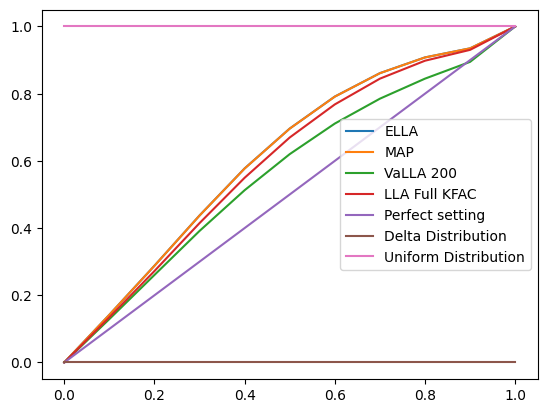

In [298]:
import matplotlib.pyplot as plt

columns = [
    ("Q-10", "mean"), ("Q-20", "mean"),("Q-30", "mean"),("Q-40", "mean"),("Q-50", "mean"),("Q-60", "mean"),
    ("Q-70", "mean"),("Q-80", "mean"),("Q-90", "mean"),
    ]

x = np.arange(0., 1.1, 0.1)
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'ELLA'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "ELLA")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'MAP'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "MAP")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'VaLLA' and M == 200").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 200")
plt.plot(x, [0, *regression.query("dataset == 'Airline' and model == 'LLA' and hessian == 'kron' and subset == 'all'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "LLA Full KFAC")
plt.plot(x, x, label = "Perfect setting")
plt.plot(x, np.zeros_like(x), label = "Delta Distribution")
plt.plot(x, np.ones_like(x), label = "Uniform Distribution")

plt.legend()
plt.show()

### Year

In [299]:
regression.query("dataset == 'Year'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

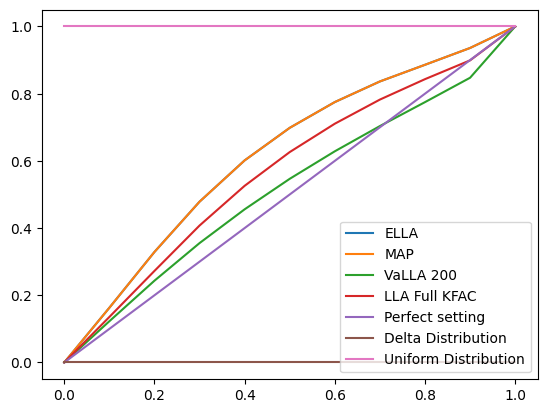

In [300]:
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'ELLA'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "ELLA")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'MAP'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "MAP")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'VaLLA' and M == 200").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 200")
plt.plot(x, [0, *regression.query("dataset == 'Year' and model == 'LLA' and hessian == 'kron' and subset == 'all'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "LLA Full KFAC")

plt.plot(x, x, label = "Perfect setting")
plt.plot(x, np.zeros_like(x), label = "Delta Distribution")
plt.plot(x, np.ones_like(x), label = "Uniform Distribution")

plt.legend()
plt.show()

### Taxi

In [301]:
regression.query("dataset == 'Taxi'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

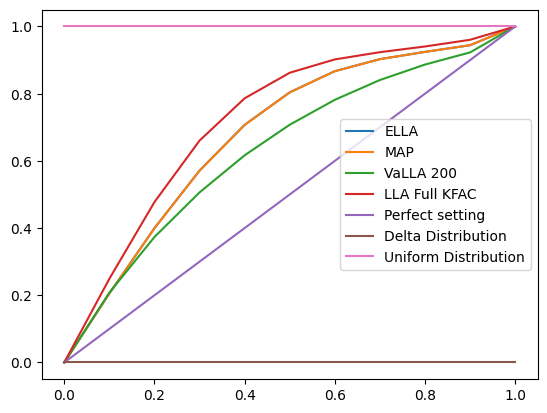

In [302]:
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'ELLA' and M == 2000").reset_index()[columns].to_numpy().flatten(), 1],
         label = "ELLA")

plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'MAP'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "MAP")
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'VaLLA' and M == 200").reset_index()[columns].to_numpy().flatten(), 1],
         label = "VaLLA 200")
plt.plot(x, [0, *regression.query("dataset == 'Taxi' and model == 'LLA' and hessian == 'kron' and subset == 'all'").reset_index()[columns].to_numpy().flatten(), 1],
         label = "LLA Full KFAC")

plt.plot(x, x, label = "Perfect setting")
plt.plot(x, np.zeros_like(x), label = "Delta Distribution")
plt.plot(x, np.ones_like(x), label = "Uniform Distribution")
plt.legend()
plt.show()

# Classification Fully-Connected 200-200

### Trainable/Validated Prior

#### CIFAR 10

In [303]:
def plot_corruptions(dataset, metric, c_values, axis):
    q = multiclass.query("dataset == '{}'".format(dataset))[[(metric + "-C"+str(i), "mean") for i in c_values]]

    axis.plot(c_values, q.query("model == 'ELLA'").to_numpy()[0], label = "ELLA")
    # axis.plot(c_values, q.query("model == 'LLA' and hessian == 'kron' and subset == 'all'").to_numpy()[0], 
    #           label = "LLA-kron")
    axis.plot(c_values, q.query("model == 'LLA' and hessian == 'kron' and subset == 'last_layer'").to_numpy()[0],
               label = "LLA*-kron")
    axis.plot(c_values, q.query("model == 'LLA' and hessian == 'diag' and subset == 'last_layer'").to_numpy()[0],
               label = "LLA*-diag")
    # axis.plot(c_values, q.query("model == 'LLA' and hessian == 'full' and subset == 'last_layer'").to_numpy()[0],
    #            label = "LLA*")
    axis.plot(c_values, q.query("model == 'MAP'").to_numpy()[0], label = "MAP")
    axis.plot(c_values, q.query("model == 'VaLLA' and M == 200").to_numpy()[0], label = "VaLLA")
    axis.set_title(metric)
    axis.legend()


In [304]:
subset =  [("ACC", "mean"), ("NLL", "mean"), ("ECE", "mean"),("BRIER", "mean"),  ("OOD-AUC", "mean"), 
           ("ACC MC", "mean"),
            ("NLL MC", "mean"),
            ("ECE MC", "mean"),
            ("BRIER MC", "mean"),  
            ("OOD-AUC MC", "mean"),
            ("prior_std", "mean"),
            ("time", "mean")]

#### FMNIST

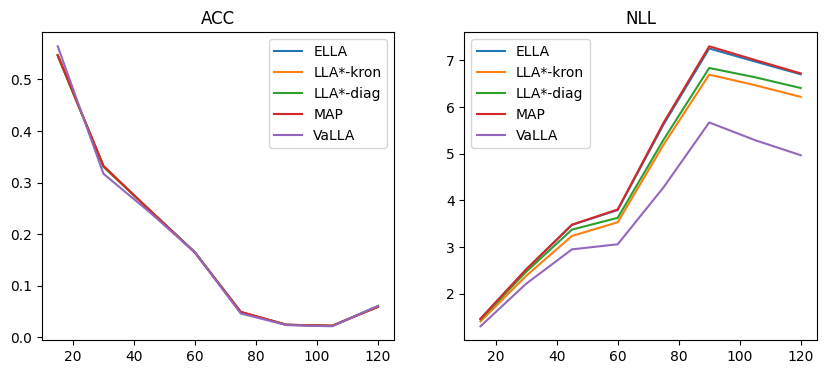

In [305]:
fig, axis = plt.subplots(1, 2, figsize=(10, 4))
plot_corruptions("FMNIST", "ACC", range(15,135, 15), axis[0])
plot_corruptions("FMNIST", "NLL", range(15, 135, 15), axis[1])
plt.show()


In [306]:
multiclass.query("dataset == 'FMNIST'")[subset].reset_index().style.background_gradient(axis=0, subset = subset) 

,dataset,model,M,subset,hessian,alpha,ACC,NLL,ECE,BRIER,OOD-AUC,ACC MC,NLL MC,ECE MC,BRIER MC,OOD-AUC MC,prior_std,time
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,FMNIST,ELLA,2000.000000,nan,nan,nan,0.865800,0.373228,0.007688,0.193102,0.873604,0.865800,0.373199,0.007998,0.193090,0.873794,1.000000,573.322306
1,FMNIST,LLA,nan,all,diag,nan,0.862400,0.397254,0.042988,0.200561,0.913897,0.864900,0.397596,0.060857,0.200713,0.907899,0.091868,240.046675
2,FMNIST,LLA,nan,all,kron,nan,0.864500,0.376684,0.013903,0.194128,0.932002,0.866000,0.373353,0.016603,0.193087,0.933494,0.183428,260.538541
3,FMNIST,LLA,nan,last_layer,diag,nan,0.865400,0.374177,0.005766,0.193613,0.878831,0.865700,0.372416,0.005173,0.192862,0.878107,0.146400,38.060245
4,FMNIST,LLA,nan,last_layer,full,nan,0.865800,0.372895,0.008490,0.192876,0.881702,0.866400,0.374573,0.009341,0.193547,0.878704,0.307297,23566.116752
5,FMNIST,LLA,nan,last_layer,kron,nan,0.865700,0.372808,0.007676,0.192930,0.880454,0.866500,0.374429,0.007307,0.193429,0.878015,0.283916,47.338321
6,FMNIST,MAP,nan,nan,nan,nan,0.865900,0.373304,0.008545,0.193116,0.873660,0.865900,0.373304,0.008545,0.193116,0.873676,nan,0.000000
7,FMNIST,VaLLA,100.000000,nan,nan,1.000000,0.873920,0.354734,0.011371,0.182381,0.923635,0.865020,0.378821,0.025822,0.195064,0.914920,0.080597,1343.748941
8,FMNIST,VaLLA,200.000000,nan,nan,1.000000,0.875140,0.352408,0.011967,0.181020,0.938556,0.865040,0.384314,0.036076,0.196679,0.930571,0.108985,511.329364


#### MNIST

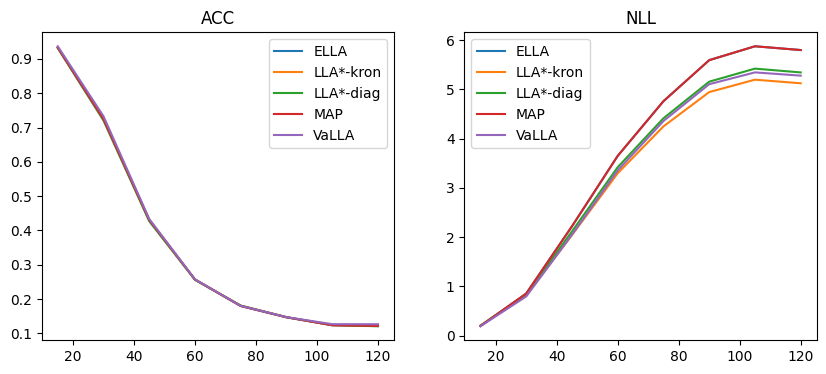

In [307]:
fig, axis = plt.subplots(1, 2, figsize=(10, 4))
plot_corruptions("MNIST", "ACC", range(15, 135, 15), axis[0])
plot_corruptions("MNIST", "NLL", range(15, 135, 15), axis[1])
plt.show()


In [308]:
multiclass.query("dataset == 'MNIST'")[subset].reset_index().style.background_gradient(axis=0, subset = subset) 

,dataset,model,M,subset,hessian,alpha,ACC,NLL,ECE,BRIER,OOD-AUC,ACC MC,NLL MC,ECE MC,BRIER MC,OOD-AUC MC,prior_std,time
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,MNIST,ELLA,2000.000000,nan,nan,nan,0.975900,0.075852,0.007844,0.036465,0.904711,0.975900,0.075852,0.007844,0.036465,0.904712,0.000100,623.398576
1,MNIST,LLA,nan,all,diag,nan,0.973600,0.143025,0.071633,0.053298,0.922130,0.975800,0.159459,0.092496,0.057600,0.936299,0.109100,242.381417
2,MNIST,LLA,nan,all,kron,nan,0.975000,0.094496,0.028624,0.040597,0.948833,0.975900,0.097906,0.035912,0.041543,0.959364,0.186259,123.012844
3,MNIST,LLA,nan,last_layer,diag,nan,0.975700,0.079959,0.012637,0.037293,0.904021,0.975900,0.079175,0.013371,0.037022,0.908101,0.189620,38.080850
4,MNIST,LLA,nan,last_layer,full,nan,0.975900,0.081351,0.015174,0.037130,0.909428,0.976000,0.080342,0.013951,0.037170,0.901225,0.383686,25015.006483
5,MNIST,LLA,nan,last_layer,kron,nan,0.975800,0.081111,0.014737,0.037156,0.908721,0.975900,0.079130,0.012213,0.037004,0.904010,0.365268,47.904012
6,MNIST,MAP,nan,nan,nan,nan,0.975900,0.075852,0.007844,0.036465,0.904711,0.975900,0.075852,0.007844,0.036465,0.904712,nan,0.000000
7,MNIST,VaLLA,100.000000,nan,nan,1.000000,0.976600,0.075722,0.010236,0.035727,0.915940,0.975900,0.078370,0.012316,0.036927,0.913674,0.033475,521.057102
8,MNIST,VaLLA,200.000000,nan,nan,1.000000,0.976880,0.075214,0.010858,0.035288,0.920580,0.975900,0.079405,0.013454,0.037145,0.917333,0.040916,2338.859631


# Classification Convolutional LeNet-5 (Trainable prior)

In [309]:

res1 = [i for i in glob.glob("results/MAP_Conv_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
map =pd.concat(df)
map

,Unnamed: 0,LOSS,NLL,ACC,ECE,BRIER,NLL MC,ACC MC,ECE MC,BRIER MC,...,BRIER MC-C3,LOSS-C4,NLL-C4,ACC-C4,ECE-C4,BRIER-C4,NLL MC-C4,ACC MC-C4,ECE MC-C4,BRIER MC-C4
0,0,0.0,1.139416,0.6444,0.113426,0.495615,1.139416,0.6444,0.113425,0.495615,...,0.689647,0.0,1.942966,0.3971,0.199927,0.787576,1.942966,0.3971,0.199927,0.787576


In [310]:

res1 = [i for i in glob.glob("results/LLA_Conv_dataset*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
lla = pd.concat(df)
lla

ValueError: No objects to concatenate

In [ ]:

res1 = [i for i in glob.glob("results/VaLLA_Conv_dataset*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
valla = pd.concat(df)
valla

,Unnamed: 0,LOSS,NLL,ACC,ECE,BRIER,NLL MC,ACC MC,ECE MC,BRIER MC,...,BRIER MC-C3,LOSS-C4,NLL-C4,ACC-C4,ECE-C4,BRIER-C4,NLL MC-C4,ACC MC-C4,ECE MC-C4,BRIER MC-C4
0,0,175.996048,1.75996,0.6126,0.226574,0.596579,1.75996,0.6126,0.226574,0.596579,...,0.754202,236.036362,2.360364,0.4341,0.280192,0.815824,2.360364,0.4341,0.280192,0.815824
0,0,175.996033,1.75996,0.6126,0.226574,0.596579,1.75996,0.6126,0.226574,0.596579,...,0.754202,236.036362,2.360364,0.4341,0.280192,0.815824,2.360364,0.4341,0.280192,0.815824
0,0,175.996033,1.75996,0.6126,0.226574,0.596579,1.75996,0.6126,0.226574,0.596579,...,0.754202,236.036362,2.360364,0.4341,0.280192,0.815824,2.360364,0.4341,0.280192,0.815824
0,0,175.996048,1.75996,0.6126,0.226574,0.596579,1.75996,0.6126,0.226574,0.596579,...,0.754202,236.036362,2.360364,0.4341,0.280192,0.815824,2.360364,0.4341,0.280192,0.815824
0,0,175.996048,1.75996,0.6126,0.226574,0.596579,1.75996,0.6126,0.226574,0.596579,...,0.754202,236.036362,2.360364,0.4341,0.280192,0.815824,2.360364,0.4341,0.280192,0.815824


In [ ]:

valla["model"] = "VaLLA"
valla["time"] = valla["timer"]
valla = valla.drop("timer", axis = 1)
map["model"] = "MAP"
lla["model"] = "LLA"
df = pd.concat([map, lla, valla]).drop(
    ["LOSS", "Unnamed: 0", "iterations", "weight_decay", "MAP_iterations"], axis=1
)
multiclass = df.groupby(["model", "M", "subset", "hessian"], dropna=False).agg(["mean", std])
multiclass = multiclass.drop(["seed", "alpha","prior_std"], axis = 1)
multiclass = multiclass.dropna(axis = 1, how = 'all')
multiclass

TypeError: agg function failed [how->mean,dtype->object]